# Projet 3:  Concevez une application au service de la santé publique
--------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------

# P3_Part1 - Nettoyage des données
--------------------------------------------------------

# 1. Contexte
--------------------------------------

L'idée d'application, avec test de faisabilité, portera sur la similarité d'un produit recherché selon les caractéristiques des produits (energie,...).

La pré-prototype de l'application sera dans un premier temps, un moteur de recommandation : à partir de la recherche d'un produit, la liste des produits les plus sains classés par score (le nombre de g de protéines le plus faible possible, produit le plus sain donc nutri-score le plus bas) sera proposée, après interrogation du jeu de données nettoyés et imputés à partir de la base de données d'Open Food Facts.

In [1]:
# Chargement des librairies
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import sys
import missingno as msno 
import warnings
import re
import fonctions_data


from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# Versions 
print('Version des librairies utilisées :')
print('Python        : ' + sys.version)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Matplotlib    : ' + mpl.__version__)
print('Seaborn       : ' + sns.__version__)

import datetime
now  = datetime.datetime.now().isoformat()
print('Lancé le           : ' + now)

Version des librairies utilisées :
Python        : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
NumPy         : 1.20.1
Pandas        : 1.2.4
Matplotlib    : 3.3.4
Seaborn       : 0.11.1
Lancé le           : 2023-06-21T20:42:10.647401


In [2]:
dico_pd_option = {
    'display.max_rows': 400,
    'display.max_column': 200,
    'display.width': 100,
    'display.precision': 5,
    'display.max_colwidth': 200
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

In [316]:
# Chargement du jeu de données, séparateur = tabulation d'après la description des variables
data = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t')
data.head()

C:\Users\yanni\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.1 - Filtrage sur les produits francais

Le but de notre application est de suggérer des produits similaires. De plus, nous souhaitons utiliser au maximum le nutriscore français. C'est pourquoi nous décidons ici de ne garder que les produits français pour notre étude.

Pour cela, regardons la colonne des pays et nous pouvons remarquer que chaque pays peut être présent sous au moins 2 formes différentes qui sont insensibles à la casse :

Le nom du pays lui-même : "France" ou "france"
Le code du pays ("fr" pour la France) suivant un autre nom/code de pays (séparé par deux points) : "en:fr" par exemple.
Nous utilisons donc des expressions régulières pour isoler ces 2 cas et filtrer nos pays pour ne garder que les produits français.

## 1 - Descriptif du dataset

In [317]:
# Dimension des données

print ("Le dataset compte {} lignes et {} variables".format(data.shape[0], data.shape[1]))

Le dataset compte 320772 lignes et 162 variables


In [51]:
# Nom des colonnes
data.columns.to_list()

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_fr',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_fr',
 'ingredients_text',
 'allergens',
 'allergens_fr',
 'traces',
 'traces_tags',
 'traces_fr',
 'serving_size',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_tags',
 'nutritio

-------------------------------------------------------------
Type de variable pour chacune des variables



code                        object
url                         object
creator                     object
created_t                   object
created_datetime            object
                            ...   
carbon-footprint_100g      float64
nutrition-score-fr_100g    float64
nutrition-score-uk_100g    float64
glycemic-index_100g        float64
water-hardness_100g        float64
Length: 162, dtype: object

,Nombre par type de variable,% des types de variable
float64,106,65.430000
object,56,34.570000


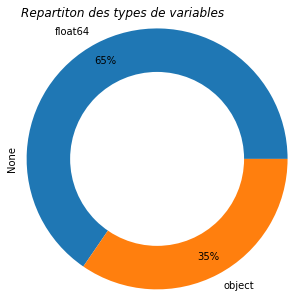

In [5]:
# Types des variables
fonctions_data.affichage_types_var(data, True, True, True)

In [6]:
# Suivi des dimensions
data.describe(include=[np.number])

,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,0.0,248939.000000,248939.000000,0.0,248939.000000,0.0,0.0,2.611130e+05,857.000000,243891.000000,...,49.000000,3036.000000,165.000000,948.000000,0.0,268.000000,221210.000000,221210.000000,0.0,0.0
mean,NaN,1.936024,0.019659,NaN,0.055246,NaN,NaN,1.141915e+03,585.501214,12.730379,...,6.425698,31.458587,15.412121,49.547785,NaN,341.700764,9.165535,9.058049,NaN,NaN
std,NaN,2.502019,0.140524,NaN,0.269207,NaN,NaN,6.447154e+03,712.809943,17.578747,...,2.047841,31.967918,3.753028,18.757932,NaN,425.211439,9.055903,9.183589,NaN,NaN
min,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,8.000000,6.000000,NaN,0.000000,-15.000000,-15.000000,NaN,NaN
25%,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,3.770000e+02,49.400000,0.000000,...,6.300000,0.000000,12.000000,32.000000,NaN,98.750000,1.000000,1.000000,NaN,NaN
50%,NaN,1.000000,0.000000,NaN,0.000000,NaN,NaN,1.100000e+03,300.000000,5.000000,...,7.200000,23.000000,15.000000,50.000000,NaN,195.750000,10.000000,9.000000,NaN,NaN
75%,NaN,3.000000,0.000000,NaN,0.000000,NaN,NaN,1.674000e+03,898.000000,20.000000,...,7.400000,51.000000,15.000000,64.250000,NaN,383.200000,16.000000,16.000000,NaN,NaN
max,NaN,31.000000,2.000000,NaN,6.000000,NaN,NaN,3.251373e+06,3830.000000,714.290000,...,8.400000,100.000000,25.000000,100.000000,NaN,2842.000000,40.000000,40.000000,NaN,NaN


In [130]:
# Résumé des variables qualitatives

data.describe(exclude=[np.number])

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url
count,320749,320749,320770,320769,320763,320772,320772,303010,52795,104819,...,221210,91513,94491,320726,320726,320726,84366,84366,75836,75836
unique,320638,320749,3535,189636,189568,180639,180495,221347,38584,13826,...,5,14,42,1021,1021,1021,3543,3543,75836,75836
top,734756002017,http://world-fr.openfoodfacts.org/produit/3569...,usda-ndb-import,1489055829,2017-03-09T10:37:09Z,1439141742,2015-08-09T17:35:42Z,Ice Cream,Pâtes alimentaires au blé dur de qualité supér...,500 g,...,d,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",en:beverages,Boissons,http://fr.openfoodfacts.org/images/products/31...,http://fr.openfoodfacts.org/images/products/54...
freq,2,1,169868,20,20,33,33,410,201,4669,...,62763,22624,22624,168905,168905,168905,6054,6054,1,1


Valeurs manquantes :39608589 NaN pour 51965064 données (76.22 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes
water-hardness_100g,320772,100.00
caproic-acid_100g,320772,100.00
elaidic-acid_100g,320772,100.00
nucleotides_100g,320763,100.00
ingredients_that_may_be_from_palm_oil,320772,100.00
...,...,...
states_fr,46,0.01
code,23,0.01
created_datetime,9,0.00
created_t,3,0.00


-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


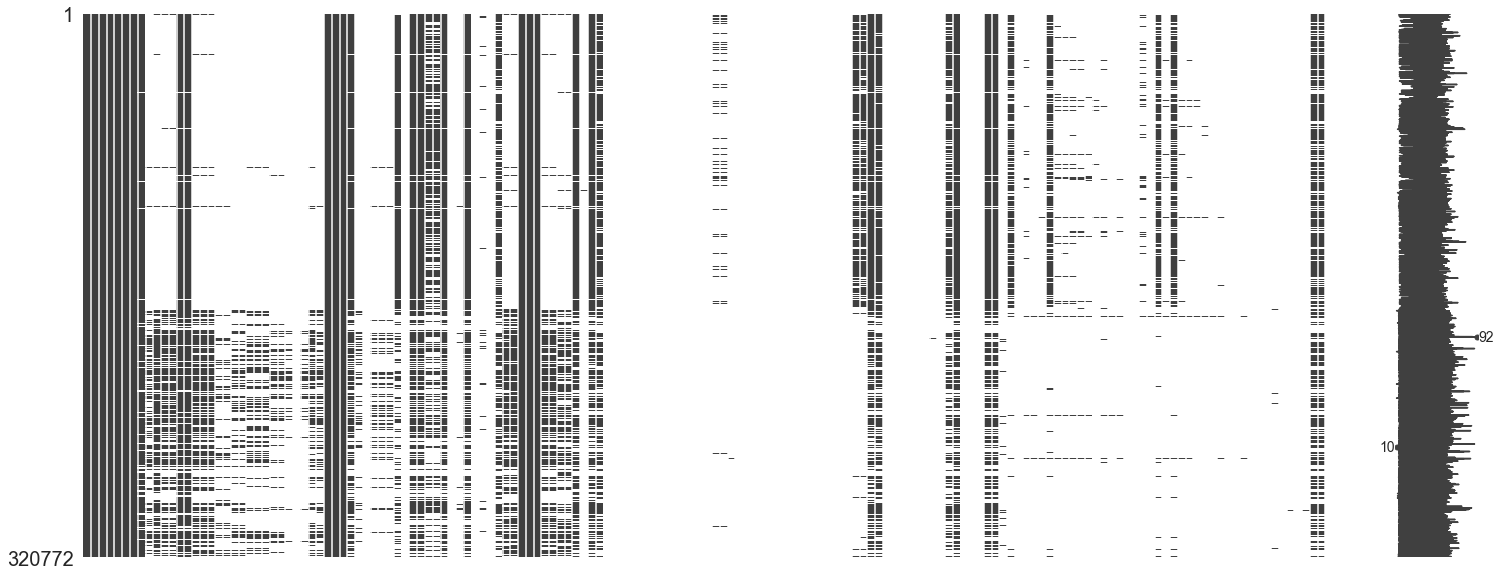

In [99]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(data, True, True)
#msno.matrix(data)

### 1.1 - Colonnes vides et doublons (nettoyage des données)

Identifions maintenant les colonnes qui présentent le moins et le plus de renseignements (valeurs nulles):

In [6]:
fonctions_data.fill_var(data, tx_min = 80 , tx_max = 100)

,Variable,Taux_de_remplissage
0,last_modified_t,100.000000
1,last_modified_datetime,100.000000
2,creator,99.999377
3,created_t,99.999065
4,created_datetime,99.997194
5,code,99.992830
6,url,99.992830
7,states_fr,99.985660
8,states_tags,99.985660
9,states,99.985660


In [8]:
fl_null_tx = fonctions_data.null_var(data, 90)
fl_null_tx


,Variable,Taux_de_Null
0,water-hardness_100g,100.000000
1,no_nutriments,100.000000
2,ingredients_that_may_be_from_palm_oil,100.000000
3,nutrition_grade_uk,100.000000
4,nervonic-acid_100g,100.000000
...,...,...
95,traces,92.408003
96,potassium_100g,92.284863
97,allergens,91.163817
98,emb_codes_tags,90.864851


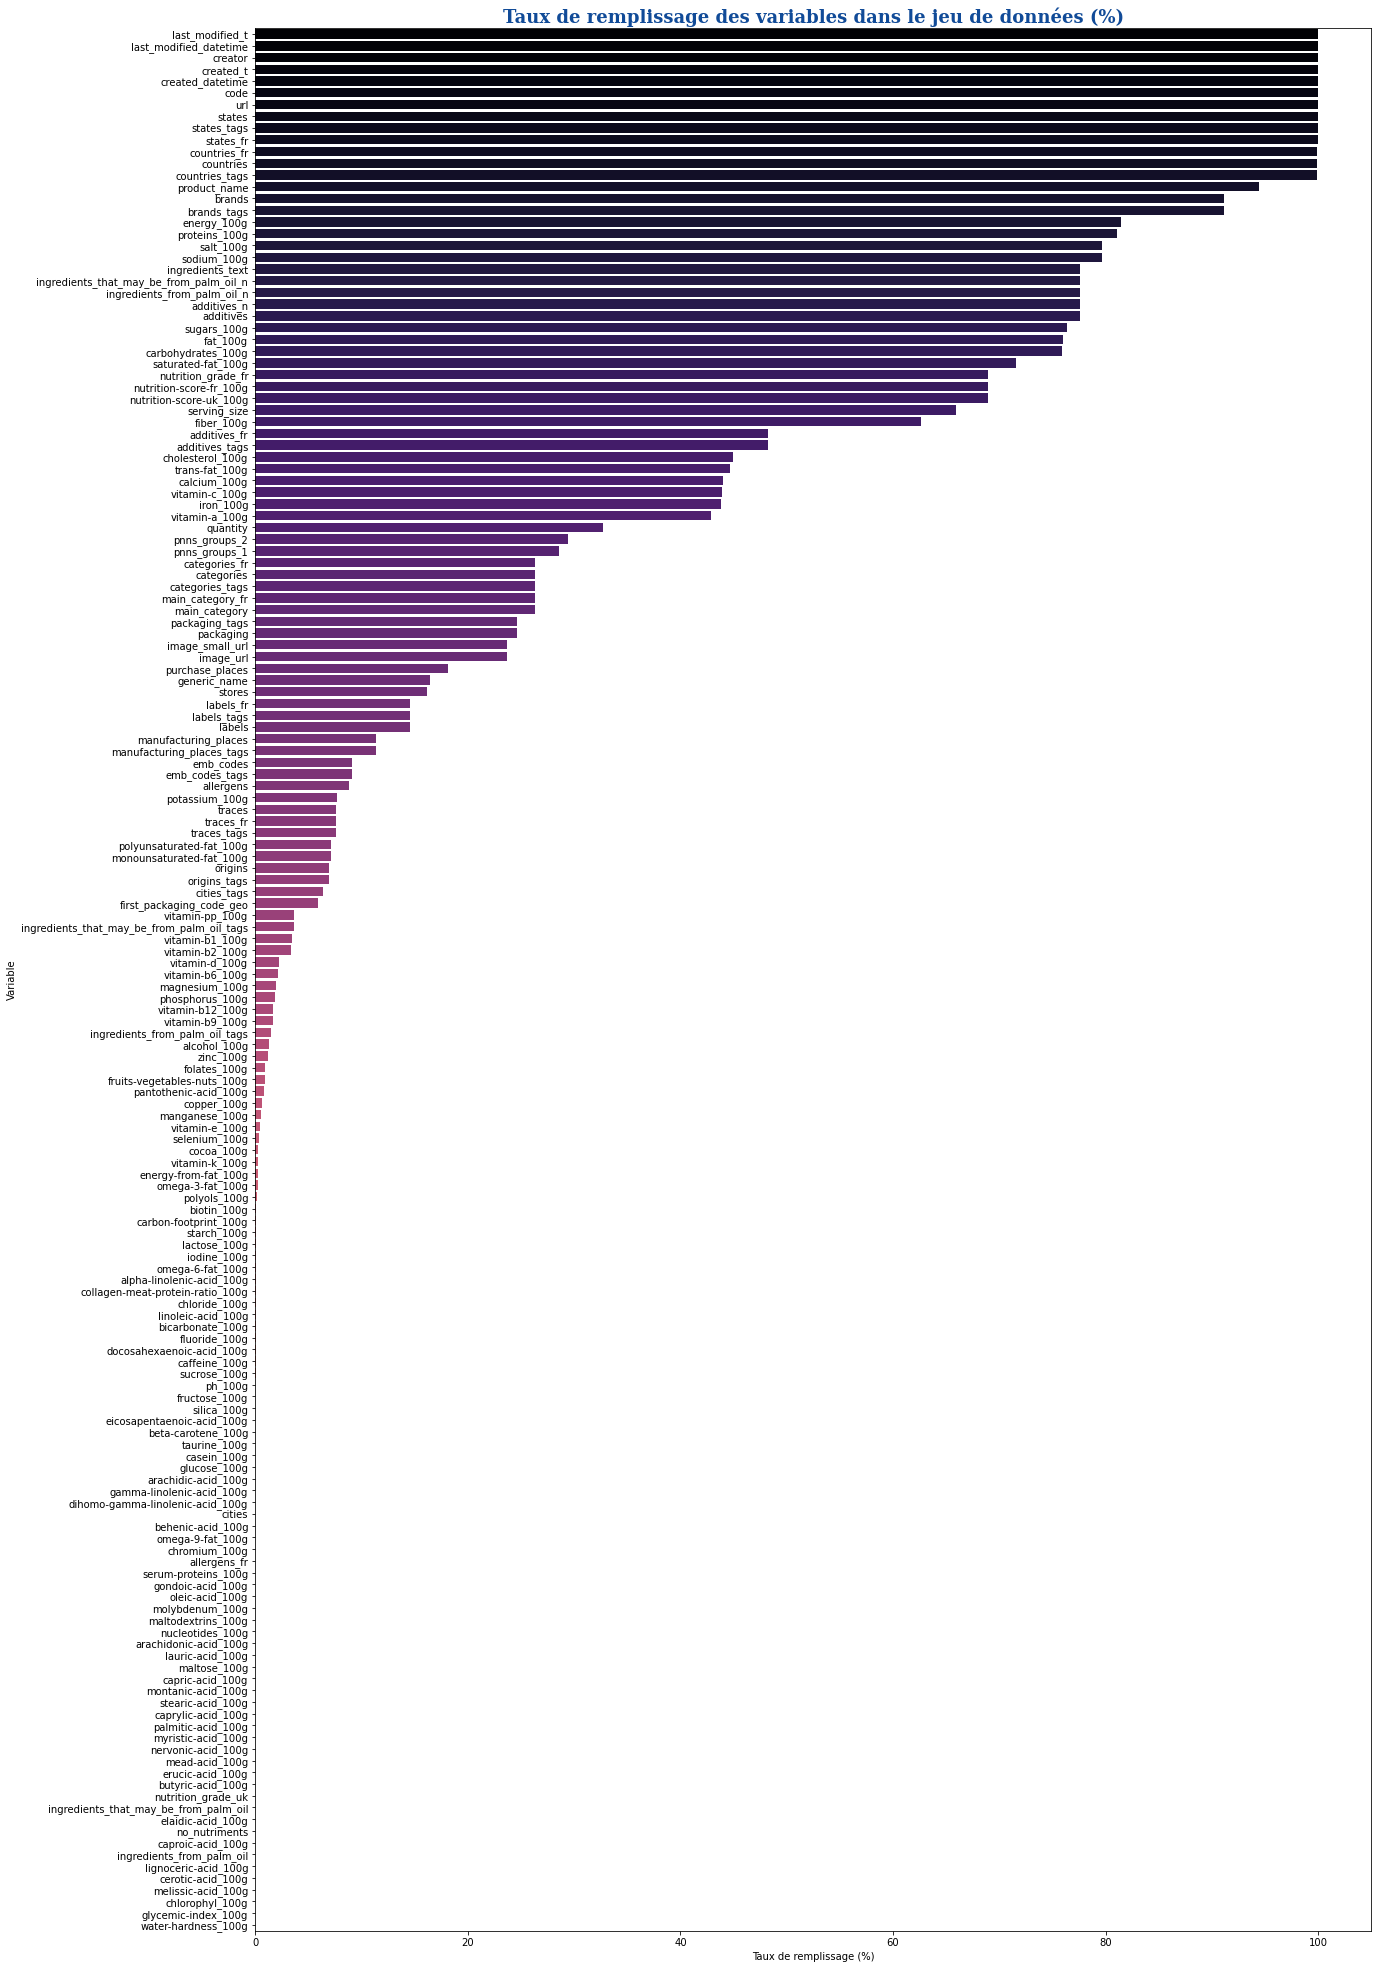

In [57]:
filling_var = fonctions_data.null_var(data, 0)
filling_var["Taux_de_Null"] = 100-filling_var["Taux_de_Null"]
filling_var = filling_var.sort_values("Taux_de_Null", ascending=False) 

#Seuil de suppression
sup_threshold = 25

fig = plt.figure(figsize=(20, 35))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

sns.barplot(x="Taux_de_Null", y="Variable", data=filling_var, palette="magma")
#Seuil pour suppression des varaibles
#plt.axvline(x=sup_threshold, linewidth=2, color = 'r')
#plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de remplissage des variables dans le jeu de données (%)", fontdict=font_title)
plt.xlabel("Taux de remplissage (%)")
plt.show()

**Suppression des variables vides**

In [318]:
data_count = data.count()
s_vide = data_count[data_count == 0]
print(f'Nombre de variables totalements vides : {len(s_vide)} \n\nListe :')
print(s_vide.index.tolist())

Nombre de variables totalements vides : 16 

Liste :
['no_nutriments', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil', 'nutrition_grade_uk', 'butyric-acid_100g', 'caproic-acid_100g', 'lignoceric-acid_100g', 'cerotic-acid_100g', 'melissic-acid_100g', 'elaidic-acid_100g', 'mead-acid_100g', 'erucic-acid_100g', 'nervonic-acid_100g', 'chlorophyl_100g', 'glycemic-index_100g', 'water-hardness_100g']


In [319]:
# Suppression des colonnes vides

data = data.dropna(axis=1, how='all')

In [320]:
# Dimension des données, après suppression

print ("Le dataset compte {} lignes et {} variables".format(data.shape[0], data.shape[1]))

Le dataset compte 320772 lignes et 146 variables


### 1.2) Formatage des caractères des variables

In [321]:
data.columns = fonctions_data.rempl_caracteres(data, '-', '_')

45 variables renommées           '-' en '_' : 

 ['energy-from-fat_100g', 'saturated-fat_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'arachidic-acid_100g', 'behenic-acid_100g', 'montanic-acid_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'alpha-linolenic-acid_100g', 'eicosapentaenoic-acid_100g', 'docosahexaenoic-acid_100g', 'omega-6-fat_100g', 'linoleic-acid_100g', 'arachidonic-acid_100g', 'gamma-linolenic-acid_100g', 'dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g', 'oleic-acid_100g', 'gondoic-acid_100g', 'trans-fat_100g', 'serum-proteins_100g', 'vitamin-a_100g', 'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'vitamin-b12_100g', 'pantothenic-acid_100g', 'fruits-vegetables-nuts_100g', 'collagen-meat-protein-ratio_10

In [11]:
data.columns.to_list()

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_fr',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_fr',
 'ingredients_text',
 'allergens',
 'allergens_fr',
 'traces',
 'traces_tags',
 'traces_fr',
 'serving_size',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_tags',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'states',
 'states_tags',
 'states_fr',


### 1.3) Doublons

In [322]:
# Doublons pour la variable 'Code'
doublons_code = data[data.duplicated(['code'], keep=False)]
nb_doublons_code = doublons_code.shape[0]
print(f'Nombre de doublons sur le code produit : {int(nb_doublons_code/2)}\nCodes doublons :')
doublons_code

Nombre de doublons sur le code produit : 122
Codes doublons :


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits_vegetables_nuts_100g,collagen_meat_protein_ratio_100g,cocoa_100g,carbon_footprint_100g,nutrition_score_fr_100g,nutrition_score_uk_100g
6,16117,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055730,2017-03-09T10:35:30Z,1489055730,2017-03-09T10:35:30Z,Organic Long Grain White Rice,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,24600,http://world-fr.openfoodfacts.org/produit/0000...,date-limite-app,1434530704,2015-06-17T08:45:04Z,1434535914,2015-06-17T10:11:54Z,Filet de bœuf,NaN,2.46 kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,31233,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055717,2017-03-09T10:35:17Z,1489055717,2017-03-09T10:35:17Z,35% Fruit And Fiber Muesli,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,58001,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055734,2017-03-09T10:35:34Z,1489055734,2017-03-09T10:35:34Z,Organic Salted Pistachios,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,15.0
194,20004552,http://world-fr.openfoodfacts.org/produit/0000...,agamitsudo,1474099741,2016-09-17T08:09:01Z,1474099768,2016-09-17T08:09:28Z,Côte du Rhône village,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280571,54491472,http://world-fr.openfoodfacts.org/produit/5449...,malikele,1340100613,2012-06-19T10:10:13Z,1489610110,2017-03-15T20:35:10Z,Coca-Cola,Boisson rafraîchissante aux extraits végétaux,50 cl,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,2.0
280572,54491496,http://world-fr.openfoodfacts.org/produit/5449...,openfoodfacts-contributors,1392388100,2014-02-14T14:28:20Z,1480085115,2016-11-25T14:45:15Z,Diet coke,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
281938,58449410003,http://world-fr.openfoodfacts.org/produit/5844...,openfoodfacts-contributors,1479577770,2016-11-19T17:49:30Z,1479577773,2016-11-19T17:49:33Z,Natures Path organic frosted berry toaster pas...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300376,78742087108,http://world-fr.openfoodfacts.org/produit/7874...,usda-ndb-import,1489135967,2017-03-10T08:52:47Z,1489135967,2017-03-10T08:52:47Z,Juice Cocktail Blended With Another Juice From...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [323]:
# Suppression des doublons sur le code produit
data.drop_duplicates(subset='code', keep='first', inplace=True)

# Dimension des données, après suppression

print ("Le dataset compte {} lignes et {} variables".format(data.shape[0], data.shape[1]))

Le dataset compte 320639 lignes et 146 variables


### Filtrage sur les variables séléctionnées

Nous utilisons la liste de variables disponible sur le site.

Pour créer notre application, nous aimerions disposer de ce type de variables :

- Le nom du produit
- Diverses informations nutritionnelles pour créer nos graphiques en araignée
- Les étiquettes pour trouver un éventuel label bio
- Le nutriscore français du produit pour comparer les produits
- Les catégories de produits afin de comprendre de quel type de produit il s'agit
- Eventuellement une image du produit 

**Exploration des données manquantes**

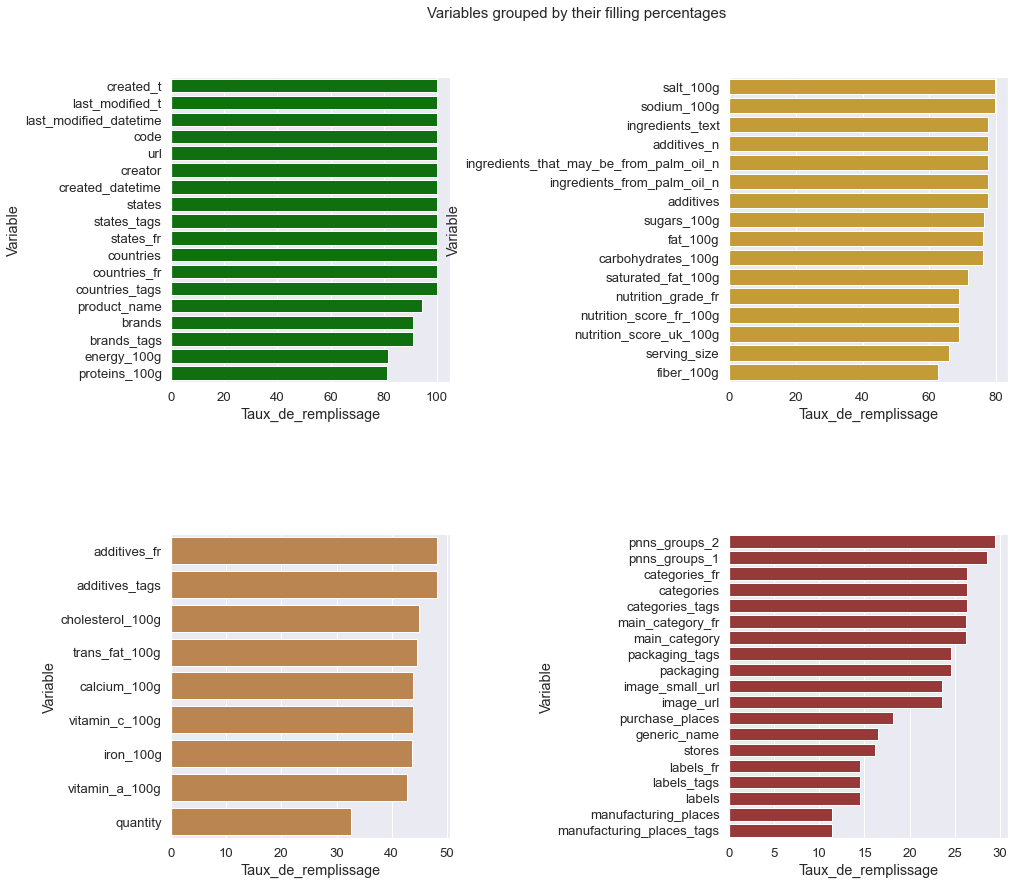

In [295]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,14))
fig.suptitle('Variables grouped by their filling percentages', fontsize=15, y=0.95)
fig.subplots_adjust(hspace=0.5, wspace=1)


fonctions_data.plot_var_filling (data, 80, 100, graph=True, axe = axes[0][0] , col = "green")
fonctions_data.plot_var_filling (data, 60, 80, graph=True, axe = axes[0][1] , col = "goldenrod")
fonctions_data.plot_var_filling (data, 30, 60, graph=True, axe = axes[1][0] , col = "peru")
fonctions_data.plot_var_filling (data, 10, 30, graph=True, axe = axes[1][1] , col = "brown")

**Validation des variables PNN**

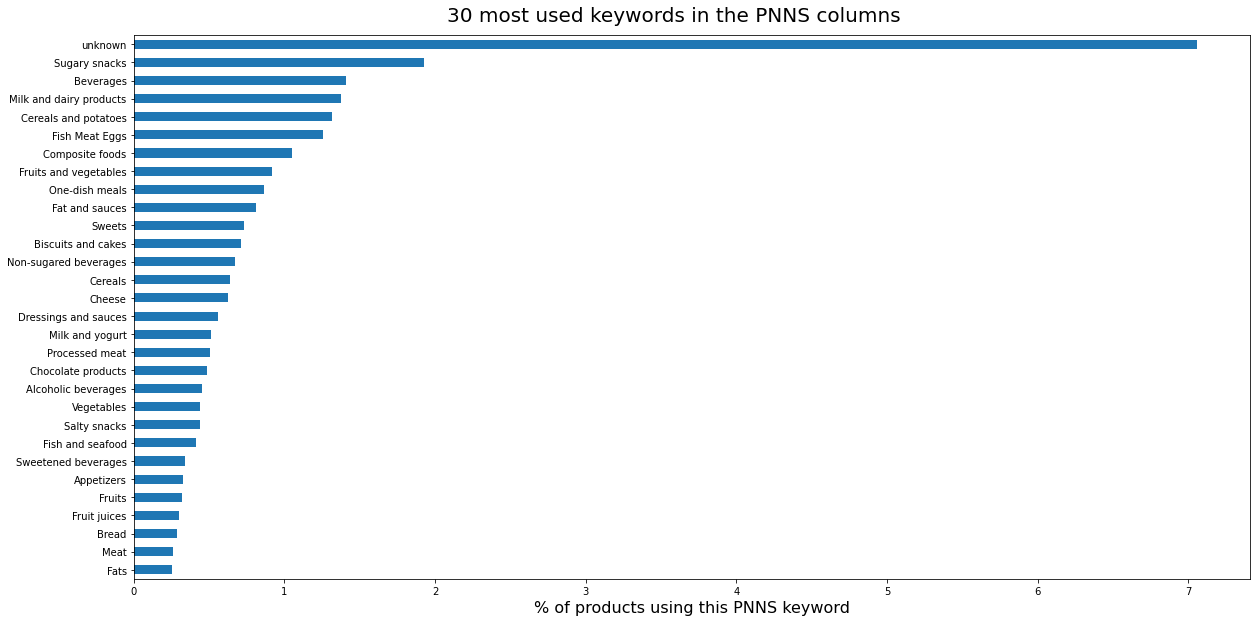

In [56]:
pnns = (pd.concat([data['pnns_groups_1'], data['pnns_groups_2']])).value_counts()

# The *2 factor is present because we concatenate 2 PNNS columns so we have twice the lenght of the initial DF
pnns = pnns * 100 / (len(data) * 2)

pnns_plot_size = 30
pnns[:pnns_plot_size].plot(kind='barh', figsize=(20,10))
plt.gcf().suptitle(str(pnns_plot_size) + " most used keywords in the PNNS columns", fontsize=20, y=0.92)
plt.gca().set_xlabel("% of products using this PNNS keyword", fontsize=16)
plt.gca().invert_yaxis()

On remarque que le mot-clé "unknown" est utilisé dans 80% des cas. Donc, en fait, les variables PNNS sont vides à 80%, donc nous allons remplacer les valeurs "unknown" par des valeurs NaN pour le reste de l'analyse.

In [296]:
data.loc[data['pnns_groups_1'] == 'unknown', 'pnns_groups_1'] = np.nan
data.loc[data['pnns_groups_2'] == 'unknown', 'pnns_groups_2'] = np.nan

# The average filling percentage of PNNS columns should be around 40% now
100 * (data['pnns_groups_1'].notnull().sum() + data['pnns_groups_2'].notnull().sum()) / (2 * len(data))

21.944772781851242

**Liste des variables pré-sélectionnées**

In [297]:
display_variables = ['url', 'product_name', 'image_small_url']
category_variables = ['main_category_fr', 'categories', 'categories_tags']
label_variables = ['labels_fr', 'labels_tags']
nutriscore_variables = ['nutrition_score_fr_100g', 'nutrition_grade_fr']
calculation_variables = ['energy_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g', 'fat_100g',
                        'carbohydrates_100g', 'salt_100g', 'sodium_100g', 'fiber_100g']

### 1.4) Analyse des variables sélectionnées

In [298]:
data.loc[:, 'nutrition_grade_fr'] = data['nutrition_grade_fr'].str.upper()
nutriscore_data = data[nutriscore_variables]
nutriscore_data = nutriscore_data.dropna()
nutriscore_data

,nutrition_score_fr_100g,nutrition_grade_fr
1,14.0,D
2,0.0,B
3,12.0,D
7,7.0,C
12,12.0,D
...,...,...
320742,-1.0,A
320751,-4.0,A
320757,0.0,B
320763,2.0,C


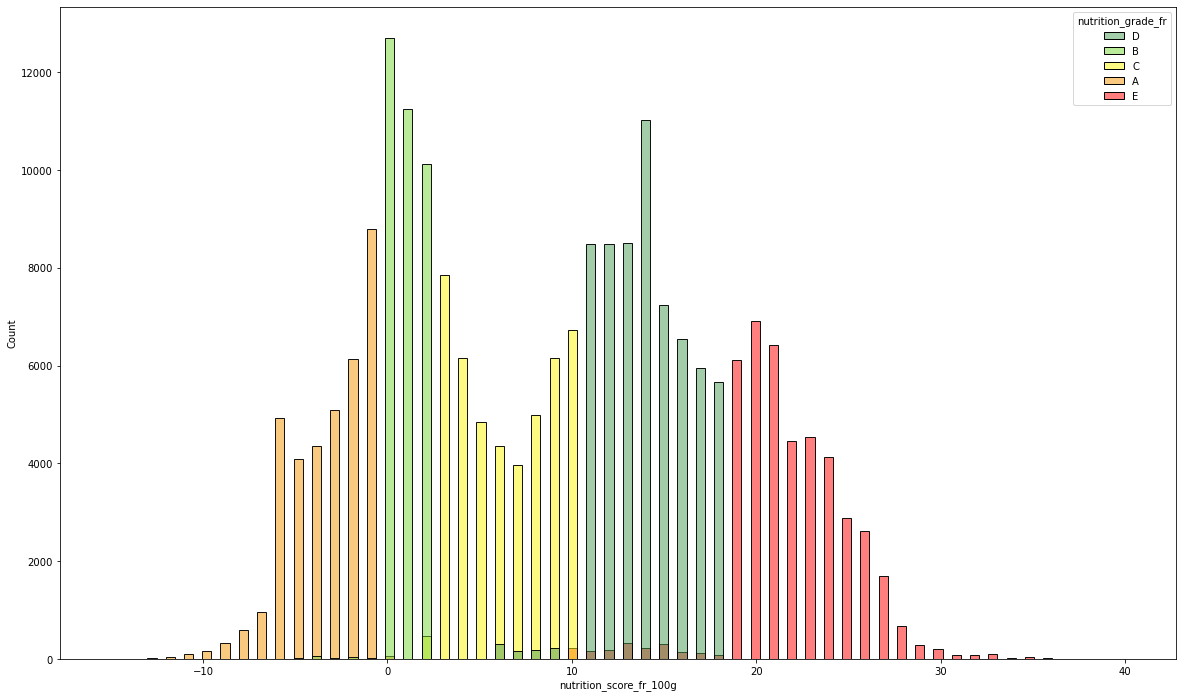

In [141]:
fig = plt.figure(figsize=(20, 12))
data.loc[:, 'nutrition_grade_fr'] = data['nutrition_grade_fr'].str.upper()
colors = ["#499A53", "#74D834", "#FBF605", "#F49402", "#FF0000"]
nutriscore_data = data[nutriscore_variables]
nutriscore_data = nutriscore_data.dropna()
sns.histplot(nutriscore_data, x='nutrition_score_fr_100g', hue='nutrition_grade_fr',palette=colors)
plt.show()

On peut constater les différentes couleurs du nutriscore francais tel que:

- Grade A : entre -15 to -1
- Grade B : entre 0 to 2
- Grace C : entre 3 to 10
- Grade D : entre 11 to 18
- Grade E : entre 19 to 40

### 1.5) Sélection des variables type 'category'

Nous avons pré-sélectionné plusieurs variables catégorielles, et nous aimerions les explorer, et voir si un est meilleur que les autres. En les comparant en fonction du taux de remplissage, on constate que les catégories sont remplies aux alentours de 38 %, ce qui ne semble pas mauvais. 

In [299]:
categories_data = data[category_variables].dropna(how="all")
categories_data

,main_category_fr,categories,categories_tags
46,Filet-de-boeuf,Filet de bœuf,fr:filet-de-boeuf
174,Légumes frais,Légumes-feuilles,"en:plant-based-foods-and-beverages,en:plant-ba..."
175,Pâtisseries,"Snacks sucrés,Biscuits et gâteaux,Pâtisseries","en:sugary-snacks,en:biscuits-and-cakes,en:past..."
177,Pains,"Plant-based foods and beverages,Plant-based fo...","en:plant-based-foods-and-beverages,en:plant-ba..."
180,Pâtisseries,"Snacks sucrés,Biscuits et gâteaux,Pâtisseries","en:sugary-snacks,en:biscuits-and-cakes,en:past..."
...,...,...,...
320762,pl:Szprot,pl:Szprot,pl:szprot
320763,Thés verts,thés verts,"en:plant-based-foods-and-beverages,en:beverage..."
320765,Produits à tartiner salés,"Viandes,Produits à tartiner,Charcuteries,Produ...","en:meats,en:spreads,en:prepared-meats,en:salte..."
320766,Fruits à coques,Peanuts,"en:plant-based-foods-and-beverages,en:plant-ba..."


**Etude du contenu des catégories de tags**

In [300]:
split_tags_count = (categories_data['categories_tags'].str.split(',', expand=True).stack().value_counts()).to_frame()
split_tags_count.columns = ['Nb of products']

# A tag could be used twice in a product but we do not consider this case below
split_tags_count['% of products'] = 100 * split_tags_count ['Nb of products'] / len(data)
split_tags_count

,Nb of products,% of products
en:plant-based-foods-and-beverages,26602,8.296558
en:plant-based-foods,22688,7.075870
en:beverages,11946,3.725685
en:sugary-snacks,11414,3.559767
en:dairies,9302,2.901082
...,...,...
fr:cidres-gazeifies,1,0.000312
es:higos-con-nueces,1,0.000312
en:poelees,1,0.000312
fr:raviolis-au-chevre,1,0.000312


L'utilisation de chaque mot clé est très variable: elle constitue une variation entre 0.00031 % et 8.29656 %. Etudions à présent sa distribution.

Text(103.0, 0.5, 'Nombre de mots clés')

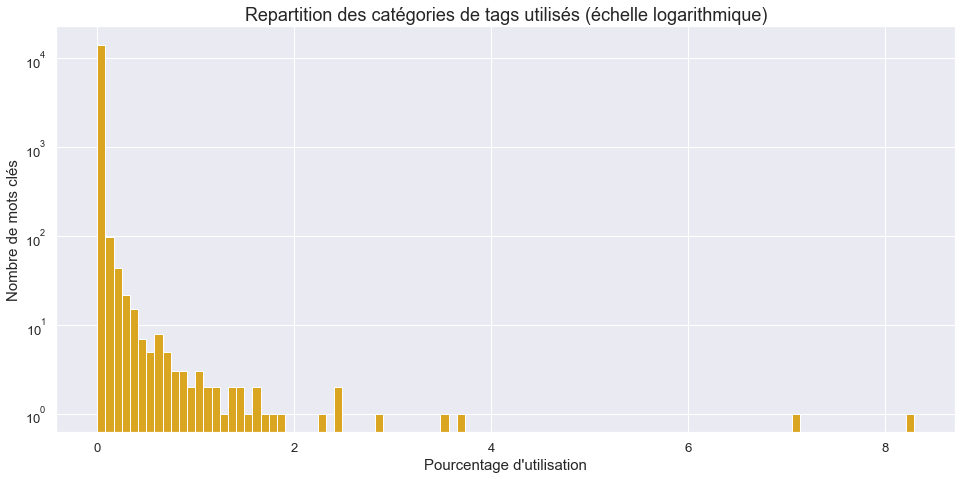

In [301]:
fig, ax = plt.subplots(figsize=(15,8))
fig.tight_layout(pad=5.0)

# Repartition of keywords by number of uses 
split_tags_count['% of products'].plot(kind="hist", ax=ax, color="goldenrod", logy=True, bins=100)
ax.set_title("Repartition des catégories de tags utilisés (échelle logarithmique)", fontsize=18)
ax.set_xlabel("Pourcentage d'utilisation", fontsize=15)
ax.set_ylabel("Nombre de mots clés", fontsize=15)

In [302]:
# Dénombrement du pourcentage de tags utilisés inférieur à 
once_percent = round(100 * len(split_tags_count[split_tags_count['Nb of products'] == 1]) / len(split_tags_count),2)
print("Pourcentage de tags utilisés une fois : " + str(once_percent) + "%")

Pourcentage de tags utilisés une fois : 58.75%


Donc, 58.75 % des tags sont uniquement utilisés par un seul produit. On les retient tous, n'ayant aucun intéret de les remplacer par des manquants (NaN)

**Etude du contenu des catégories principales (main category)**

Pourcentage des catégories utilisées une seule fois : 77.98%


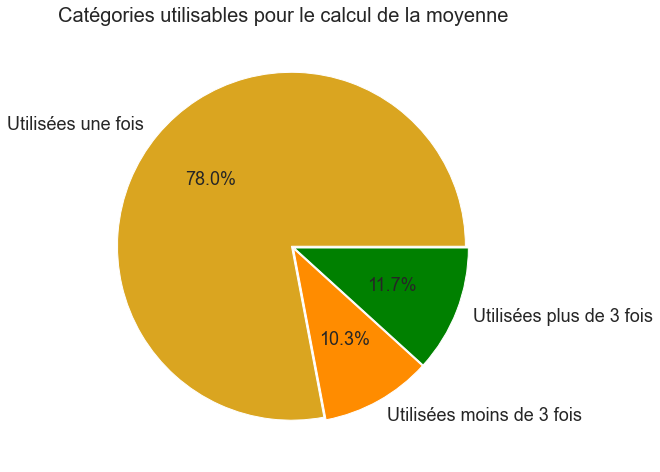

In [303]:
categories_count = categories_data['main_category_fr'].value_counts().to_frame()
once_percentage = round(100 * len(categories_count[categories_count['main_category_fr'] == 1]) / len(categories_count),2)
print("Pourcentage des catégories utilisées une seule fois : " + str(once_percentage) + "%")

# Pie chart pour afficher combien de catégories sont utilisées en fréquence, avec un seuil donné
USE_THRESHOLD=3
pie_chart_data = {
    'Utilisées une fois': len(categories_count[categories_count['main_category_fr'] == 1]),
    'Utilisées moins de ' + str(USE_THRESHOLD) + ' fois' : len(categories_count[(categories_count['main_category_fr'] > 1) & (categories_count['main_category_fr'] < USE_THRESHOLD)]),
    'Utilisées plus de ' + str(USE_THRESHOLD) + ' fois' : len(categories_count[categories_count['main_category_fr'] >= USE_THRESHOLD])
}

fig = plt.figure(figsize=(8,8))
plt.suptitle("Catégories utilisables pour le calcul de la moyenne ", fontsize=20, y=0.92)
plt.pie(pie_chart_data.values(), 
        labels=pie_chart_data.keys(), 
        autopct="%.1f%%", 
        explode=[0.01]*3, 
        colors=["goldenrod", "darkorange", "green"],
        textprops={'size': 18})
plt.show()

Encore une fois, la majorité des catégories sont utilisées une seule fois pour un produit dans le dataset. Nous les retenons, mais en gardant à l'esprit le traitement des valeurs manquantes.

**Etude sur le label organic**

Pour le label 'organic', on ajoute une colonne booléenne comme 'Vrai' si le label contient le terme 'organic' ou 'bio' (pour correspondre les termes francais et anglais de 'organic') 

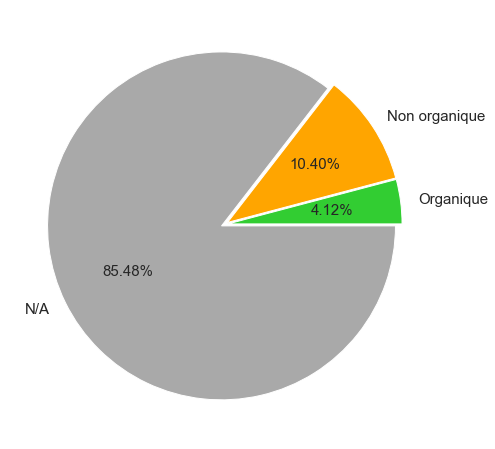

In [304]:
data['organic'] = data['labels'].str.contains('(?:organic)|(?:bio)', case=False, regex=True)
total_organic_products = len(data[data['organic'] == True])
total_non_organic_products = len(data[data['organic'] == False])
total_null_organic_products = len(data[data['organic'].isnull() == True])

plt.figure(figsize=(8,8))
plt.pie([total_organic_products, total_non_organic_products, total_null_organic_products],
        autopct="%.2f%%", 
        labels=["Organique", "Non organique", "N/A"], 
        colors=['limegreen', 'orange', 'darkgrey'],
        explode=[0.02]*3,
        textprops={'size': 15})
plt.show()

**Comparaison entre la colonne 'salt' et 'sodium'**

Nous avons conservé les deux colonnes sodium et sel, mais normalement une seule devrait être utile, car le sodium d'un produit est apporté par le sel (le sel contient 40% de sodium).

Nous allons vérifier cela en traçant la quantité de sodium en fonction de la quantité de sel, puis en fusionnant les 2 colonnes en conservant le rapport moyen entre elles.

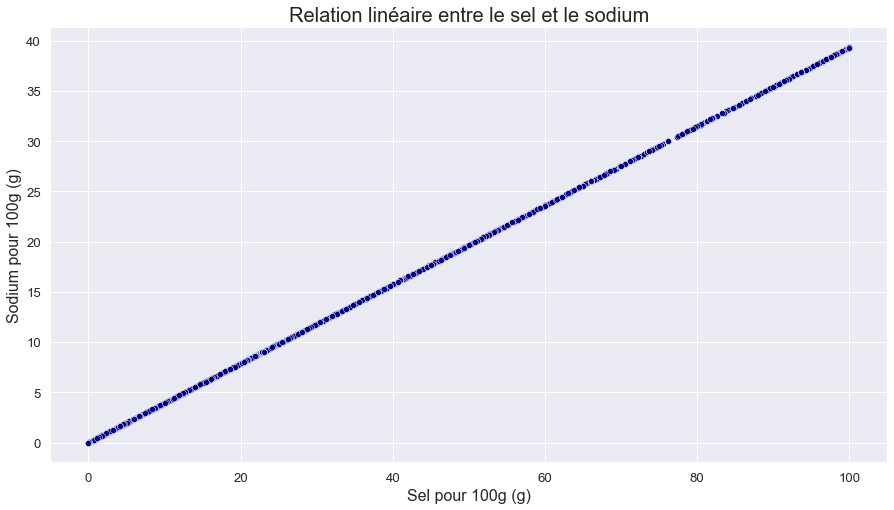

In [203]:
# Plotting salt/sodium linear relation
salt_sodium_data = data[(data['salt_100g'] <= 100) & (data['sodium_100g'] <= 100)].filter(['salt_100g', 'sodium_100g']).dropna(how="any")

fig = plt.figure(figsize=(15,8))
plt.gca().set_title("Relation linéaire entre le sel et le sodium", fontsize=20)
plt.gca().set_xlabel("Sel pour 100g (g)", fontsize=16)
plt.gca().set_ylabel("Sodium pour 100g (g)", fontsize=16)
sns.scatterplot(x=salt_sodium_data['salt_100g'], y=salt_sodium_data['sodium_100g'], color="darkblue")

# Calculating the ratio and merging the column into the salt columns
salt_sodium_ratio = data['sodium_100g'].mean() / data['salt_100g'].mean()
data.loc[(data['sodium_100g'].notnull()) & (data['salt_100g'].isnull()), 'salt_100g'] = data['sodium_100g'] / salt_sodium_ratio

### 2) Traitement des valeurs aberrantes

#### 2.1) Filtration sur les colonnes

Tout d'abord, après avoir selectionné les colonnes, on peut filtrer le dataset

In [305]:
columns_final = ['url',
                 'product_name',
                 'image_small_url',
                 'main_category_fr',
                 'categories_tags',
                 'organic',
                 'energy_100g',
                 'nutrition_score_fr_100g',
                 'saturated_fat_100g',
                 'sugars_100g',
                 'proteins_100g',
                 'fat_100g',
                 'carbohydrates_100g',
                 'salt_100g',
                 'fiber_100g',
                  'nutrition_grade_fr']


data = data.filter(columns_final, axis=1)

In [306]:
len(data['main_category_fr'].unique())

3544

#### 2.2) Colonne score de nutrition francais

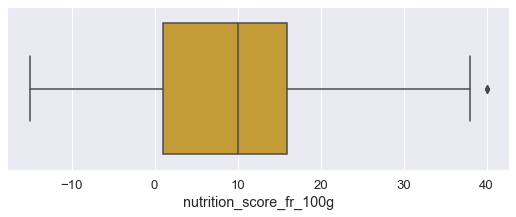

In [307]:
fonctions_data.plot_columns_boxplots(data, columns=['nutrition_score_fr_100g'])

Il n'y a aucune valeur atypique sur la distribution, comprise entre -15 et 40.

#### 2.3) Colonne energy

Nous appelons 'energy_100g' une information nutritionnelle pour 100g de produit, en terme d'apport energétique. Nous allons donc exclure toutes informations nutritionnelles du type energétique excédant les 100 g.

In [308]:
data_av = data['energy_100g'].copy()

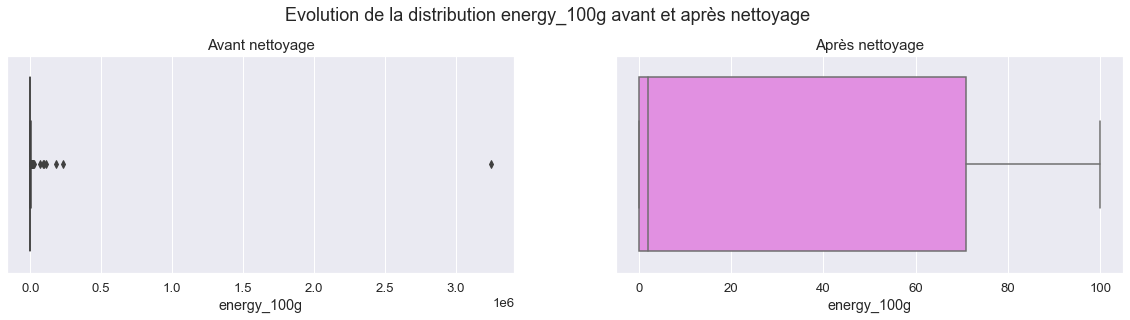

In [309]:
# Exclusion des valeurs energetiques supérieures à 100 g (energy_100g)
data.loc[data['energy_100g'] > 100, 'energy_100g'] = np.nan

# Graphe avant et après nettoyage
fig, axs = plt.subplots(figsize=(20,4), ncols=2, nrows=1)
fig.suptitle('Evolution de la distribution energy_100g avant et après nettoyage', fontsize=18, y=1.05)
axs[0].set_title('Avant nettoyage', fontsize=15)
axs[1].set_title('Après nettoyage', fontsize=15)
sns.boxplot(x=data_av, ax=axs[0], color="firebrick")
sns.boxplot(x=data['energy_100g'], ax=axs[1], color="violet")
plt.show()

#### 2.4) Colonne nutritionnelle

On dénomme les colonnes 'nutritional', toutes les colonnes contenant une information nutritionnelle pour 100g de produit, incluant le nutriscore francais.

In [310]:
# Stockage des données avant nettoyage
nutri_cols = fonctions_data.get_nutri_col(data)
nutri_data_av = data[nutri_cols].copy()
applied_filters = {'Initial dataset': len(data)}

In [311]:
data.shape

(320639, 16)

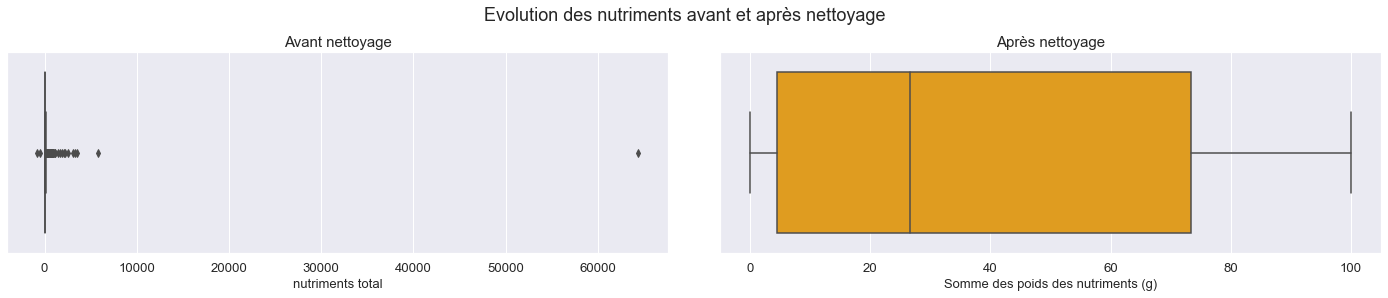

In [312]:
# Nouvelle colonne contenant le poids total des nutriments
nutrient_columns = fonctions_data.get_nutri_col(data, cols_suppr=['sugars_100g', 'saturated_fat_100g', 'energy_100g', 'nutrition_score_fr_100g'])
data['nutriments total'] = data[nutrient_columns].sum(axis=1)
nutri_data_av['nutriments total'] = nutri_data_av[nutrient_columns].sum(axis=1)

fig, axs = plt.subplots(figsize=(20,4), ncols=2)
fig.suptitle('Evolution des nutriments avant et après nettoyage', fontsize=18)
fig.tight_layout(pad=1.0)

# Graphe avant nettoyage des données
axs[0].set_title("Avant nettoyage", fontsize=15)
axs[0].set_xlabel("Somme des poids des nutriments (g)", fontsize=13)
sns.boxplot(x=nutri_data_av['nutriments total'], color="blue", ax=axs[0]) 

# Retrait des valeurs aberrantes (de 0 à 100)
data = data[(data['nutriments total'] <= 100) & (data['nutriments total'] >= 0)]

# Boxplot après nettoyage
sns.boxplot(x=data['nutriments total'], color="orange", ax=axs[1]) 
axs[1].set_title("Après nettoyage", fontsize=15)
axs[1].set_xlabel("Somme des poids des nutriments (g)", fontsize=13)

# Retrait des colonnes inutiles
data = data.drop('nutriments total', axis="columns")

# Sauvetage de la nouvelle longueur de donnée, en historique
applied_filters['Nutriments total \n > 100g'] = len(data)

In [ ]:
data.shape

**Retrait des valeurs aberrantes**

Nous allons effectuer des boxplots, avant et après nettoyage sur les outliers, en les remplissant de NaN. On considère en tant que valeur aberrante, une valeur excédant des 100g, ou inférieur à 0. 


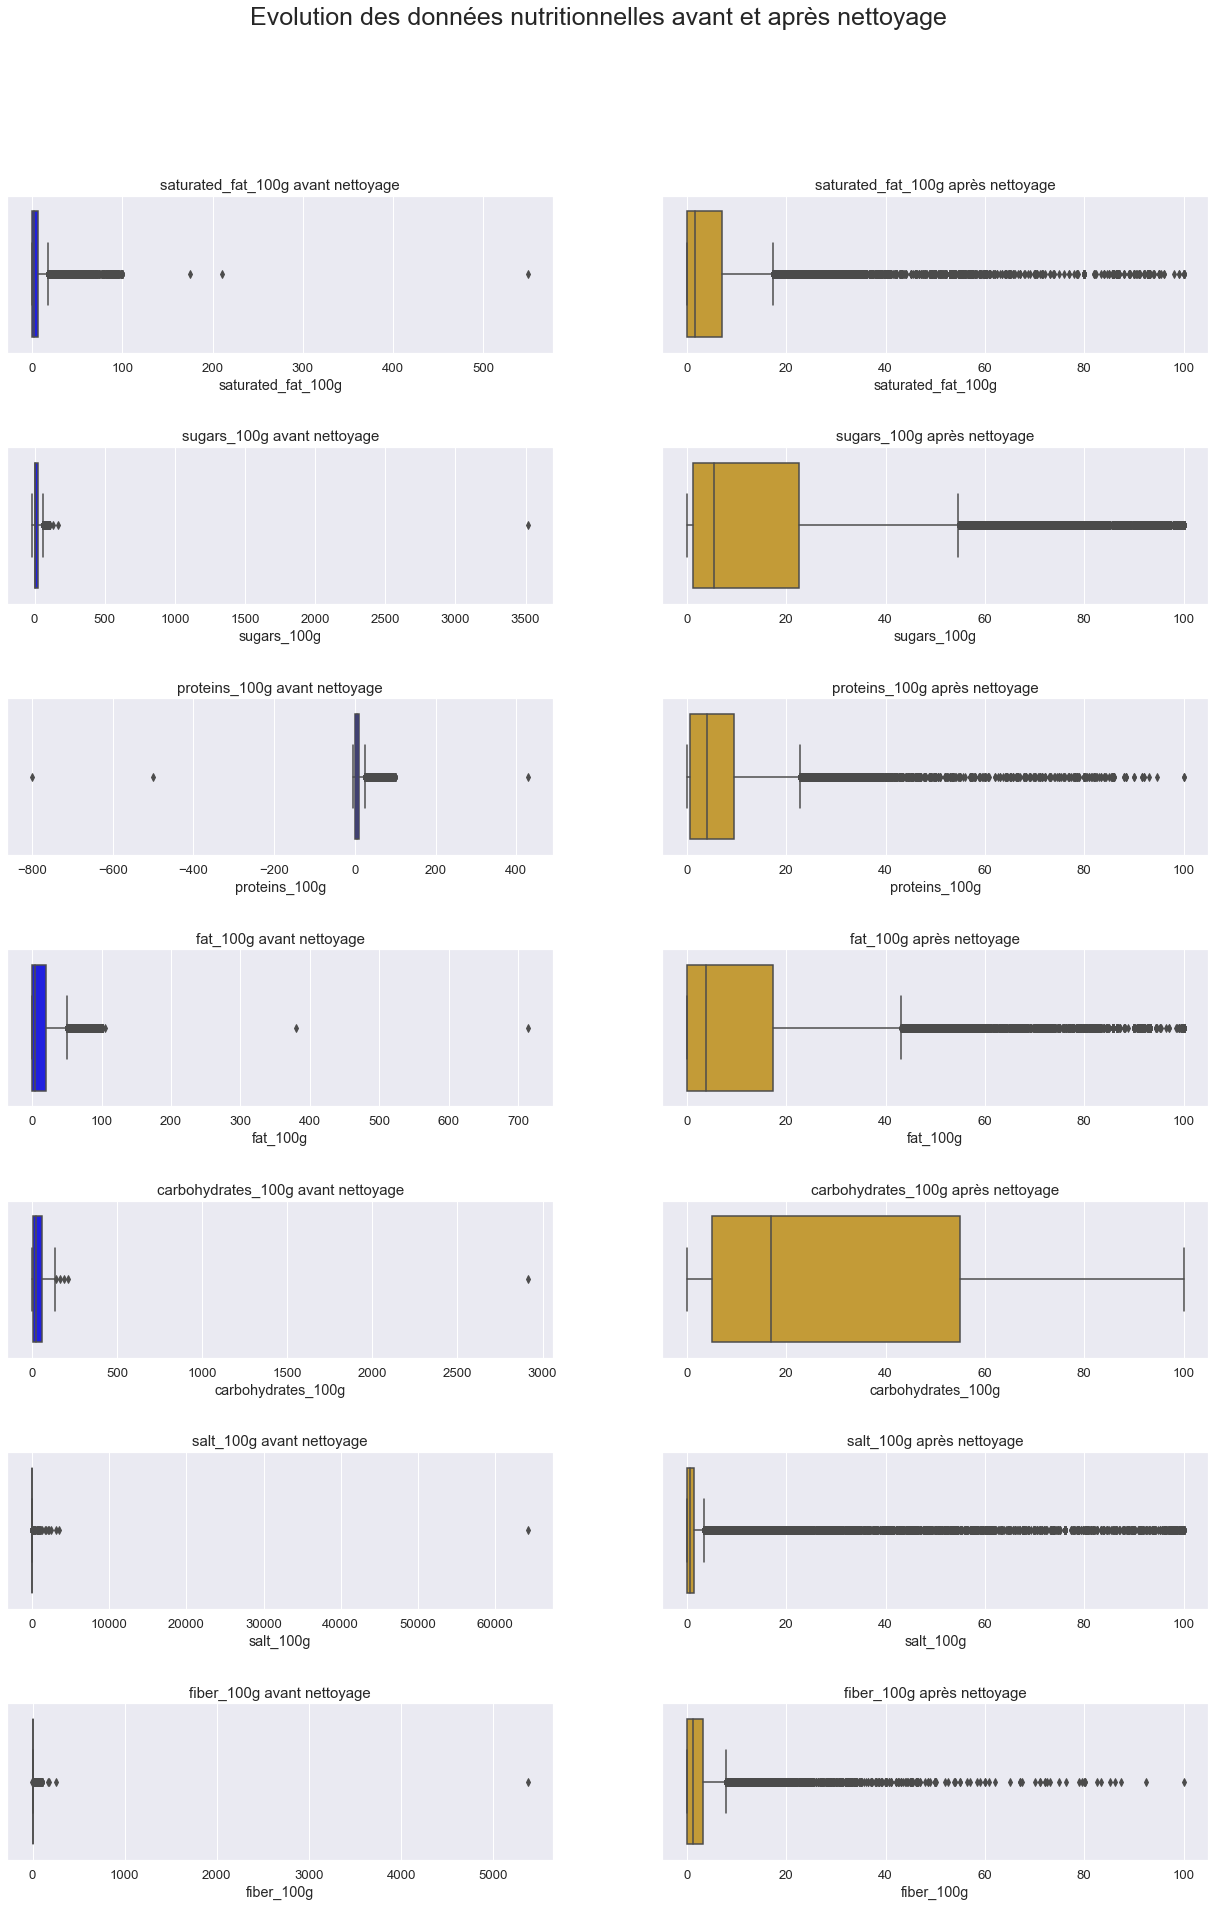

In [313]:
# Conversion des colonnes nutritionnelles/nutrscore en valeurs numériques
nutri_columns = fonctions_data.get_nutri_col(data, cols_suppr=['nutrition_score_fr_100g', 'energy_100g'])
data[nutri_columns] = data[nutri_columns].apply(pd.to_numeric)

fig, axs = plt.subplots(figsize=(20,4*len(nutri_columns)), ncols=2, nrows=len(nutri_columns))
fig.suptitle('Evolution des données nutritionnelles avant et après nettoyage', fontsize=25)
fig.tight_layout(pad=7.0)

# Nettoyage, filtrage des outliers
for index, column in enumerate(nutri_columns):
    data.loc[data[column] > 100, column] = np.nan
    data.loc[data[column] < 0, column] = np.nan
    
    axs[index][0].set_title(column + ' avant nettoyage', fontsize=15)
    sns.boxplot(x=nutri_data_av[column], ax=axs[index][0], color="blue")
    
    axs[index][1].set_title(column + ' après nettoyage', fontsize=15)
    sns.boxplot(x=data[column], ax=axs[index][1], color="goldenrod")
    plt.gcf().subplots_adjust(wspace = 0.2, hspace = 0.6)

On remarque que les boxplots pour les variables 'fats', 'proteines', et 'cabohydrates/sugars' contient plusieurs outliers. En effet, ceci s'explique par la variété des produits très-proteinés, très caloriques, très sucrés. Les boxplots pour le sel est étrange, car les produits extremement salés (plus de 40 % de sel) sont essentiellement des bouillons ou des produits à base de sel, et sont peu commun, de meme pour le boxplot pour les fibres (plus de 40 %) sont inhabituel et ne devraient pas etre abondants. En conclusion, nous avons des valeurs atypiques dans le dataset, et on se concentera la-dessus par la suite. 

### 3) Traitement des valeurs manquantes

#### 3.1) Retrait des colonnes vides

In [314]:
# Retrait de la colonne 'url' qui est remplie
sub_col = data.columns.values.tolist()
sub_col.remove('url')
data = data.dropna(how="all", subset=sub_col)

# Enregistrement de la nouvelle longueur de données pour filtrage
applied_filters['ligne vide'] = len(data)

In [315]:
data.shape

(290371, 16)

#### 3.2) Retrait des produits n'ayant aucun nom

Ces colonnes ne contient pas de valeurs aberrantes, étant de type caratère, et utilisées seulement pour l'affichage. Aucun soucis pour l'URL et l'image, mais nous ne voulons pas obtenir un nom de produit pour notre application. C'est pourquoi, on retire tous les produits n'ayant pas de nom de produit (NaN ou phrase vide).

In [261]:
data = data[(data['product_name'].notnull()) & (data['product_name'].str.contains('^\s*$') == False)]

# Enregistrement de la nouvelle longueur de données pour filtrage
applied_filters['Aucun \n nom_produit'] = len(data)

#### 3.3) Retrait des produits n'ayant beaucoup de données nutritonnelles manquantes

Les données nutritionnelles sont essentielles pour notre application parce que:
Nous les utiliserons pour calculer les scores de nutrition manquantes. On les affichera sur un graphe de comparaison pour comparer facilement les produits similaires selectionnés.  
Le but est de repérer quelle variables nutritionnelles ayant des données manquantes. Nous avons sur les 7 variables nutritionnelles selectionnés celles à retirer. 

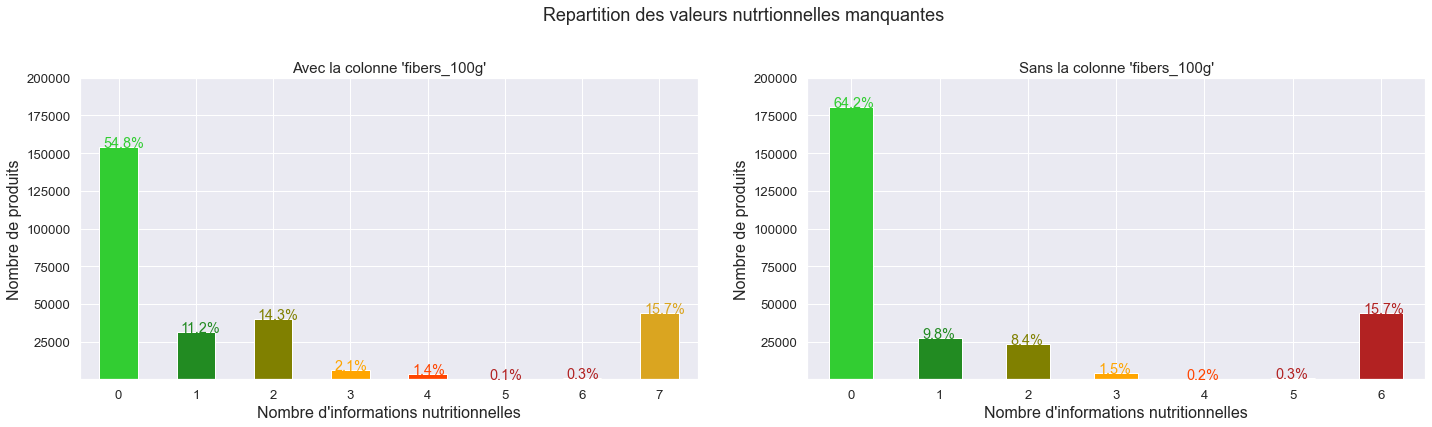

In [262]:
nutritional_columns = fonctions_data.get_nutri_col(data, cols_suppr=['nutrition_score_fr_100g', 'energy_100g'])
nutritional_columns_no_fiber = fonctions_data.get_nutri_col(data, cols_suppr=['nutrition_score_fr_100g', 'energy_100g', 'fiber_100g'])

missing_nutritional_info = data[nutritional_columns].isna().sum(axis=1).to_frame()
missing_nutritional_info.columns = ['missing values']

missing_nutritional_info_no_fiber = data[nutritional_columns_no_fiber].isna().sum(axis=1).to_frame()
missing_nutritional_info_no_fiber.columns = ['missing values']

colors = ["limegreen", "forestgreen", "olive", "orange", "orangered", "firebrick", "firebrick", "goldenrod"]

fig, axes = plt.subplots(figsize=(20,6), ncols=2)
fig.suptitle("Repartition des valeurs nutrtionnelles manquantes", fontsize=18)
fig.tight_layout(pad=2, w_pad=5)

axes[0].set_title("Avec la colonne 'fibers_100g'", fontsize=15)
missing_nutritional_info.value_counts().sort_index().plot(kind="bar", logy=False, color=colors, ax=axes[0])

axes[1].set_title("Sans la colonne 'fibers_100g'", fontsize=15)
missing_nutritional_info_no_fiber.value_counts().sort_index().plot(kind="bar", logy=False, color=colors, ax=axes[1])

for ax in axes:
    ax.set_xlabel("Nombre d'informations nutritionnelles", fontsize=16)
    ax.set_ylabel("Nombre de produits", fontsize=16)
    ax.set_ylim(ymin=100, ymax=200000)
    
for index, value in enumerate(missing_nutritional_info.value_counts().sort_index()):
    axes[0].set_xticklabels(labels=range(len(missing_nutritional_info.value_counts())), rotation=0)
    axes[0].text(index-0.2, value, str(round(100*value/len(data),1)) + "%", color=colors[index])
    
for index, value in enumerate(missing_nutritional_info_no_fiber.value_counts().sort_index()):
    axes[1].set_xticklabels(labels=range(len(missing_nutritional_info_no_fiber.value_counts())), rotation=0)
    axes[1].text(index-0.2, value, str(round(100*value/len(data),1)) + "%", color=colors[index])

Nous remarquons ici une chose très importante : comme la colonne fiber_100g est très mal remplie (environ 63% de NaN), elle introduit au moins une valeur nutritionnelle manquante dans 63% du produit. On constate que sans la colonne fibres, 65% des produits ont toutes leurs informations nutritionnelles renseignées.

C'est pourquoi nous conservons la colonne fibres pour notre application (cela nous permettra de l'afficher pour les produits qui la possèdent) mais nous l'ignorerons dans l'analyse exploratoire (deuxième notebook).

En revanche, nous pouvons supprimer tous les produits ayant 3 valeurs nutritionnelles manquantes ou plus (sans les fibres) car nous savons d'ores et déjà que nous ne pourrons pas les imputer tous sans introduire un biais.

In [263]:
data['valeurs_nutri_manquantes'] = data[nutritional_columns_no_fiber].isna().sum(axis=1)
data = data[data['valeurs_nutri_manquantes'] < 3]
data = data.drop('valeurs_nutri_manquantes', axis="columns")

# Enregistrement de la nouvelle longueur de données pour filtrage
applied_filters['Info \n nutritionelles \n manquantes'] = len(data)

#### 3.4) Suppression d'un produit sans catégorie ni tag

Cette variable est nécessaire dans le calcul de la similarité des produits. On retire, par conséquent, ceux n'ayant aucun 'tag.

In [264]:
data = data[(data['main_category_fr'].notnull()) | (data['categories_tags'].notnull())]

# Enregistrement de la nouvelle longueur de données pour filtrage
applied_filters['Aucune \n categorie/tags'] = len(data)

#### 3.5) Remplissage des valeurs manquantes

Nous allons remplir les valeurs nutritionnelles manquantes en utilisant les valeurs moyennes des produits de la même catégorie principale



In [265]:
cols = data.select_dtypes(include=[np.number]).columns.to_list()

<Figure size 720x720 with 0 Axes>

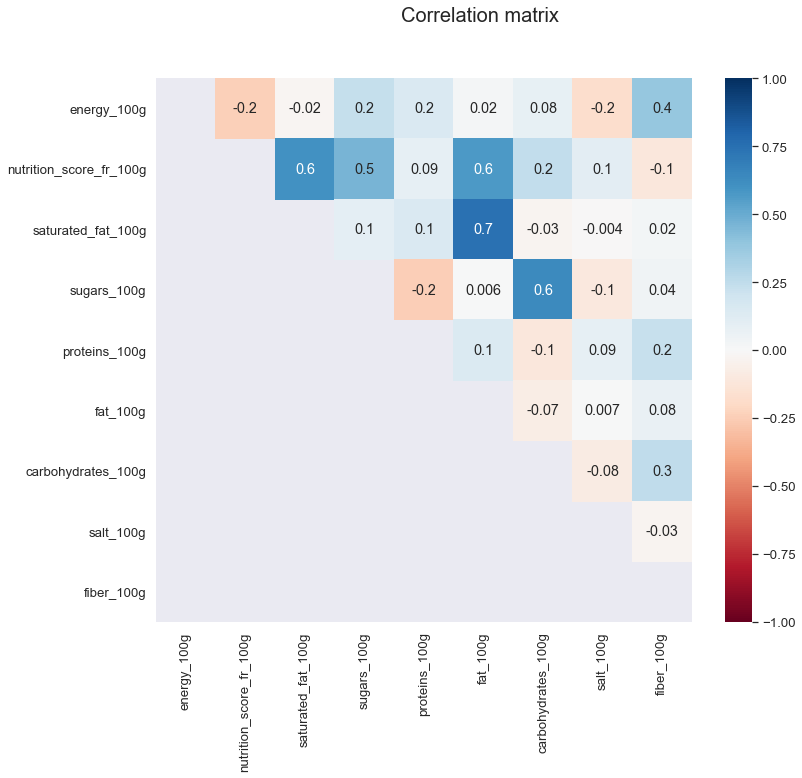

In [266]:
plt.figure(figsize=(10, 10))
corr = data[cols].corr(method='pearson')
#outils_visu.corrplot(corr)

correlation_matrix = data.corr(method='pearson')
triangular_matrix = np.tril(correlation_matrix)

fig, ax = plt.subplots(figsize=(12,10)) 
fig.suptitle("Correlation matrix", fontsize=20)
sns.heatmap(correlation_matrix, annot=True, fmt='.1g', mask=triangular_matrix, vmin=-1, vmax=1, cmap= 'RdBu')
plt.show()

Valeurs manquantes :134660 NaN pour 940992 données (14.31 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes
energy_100g,56335,95.79
organic,27373,46.54
fiber_100g,21564,36.67
image_small_url,16610,28.24
carbohydrates_100g,2942,5.00
fat_100g,2824,4.80
nutrition_score_fr_100g,2313,3.93
nutrition_grade_fr,2313,3.93
saturated_fat_100g,810,1.38
sugars_100g,774,1.32


-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


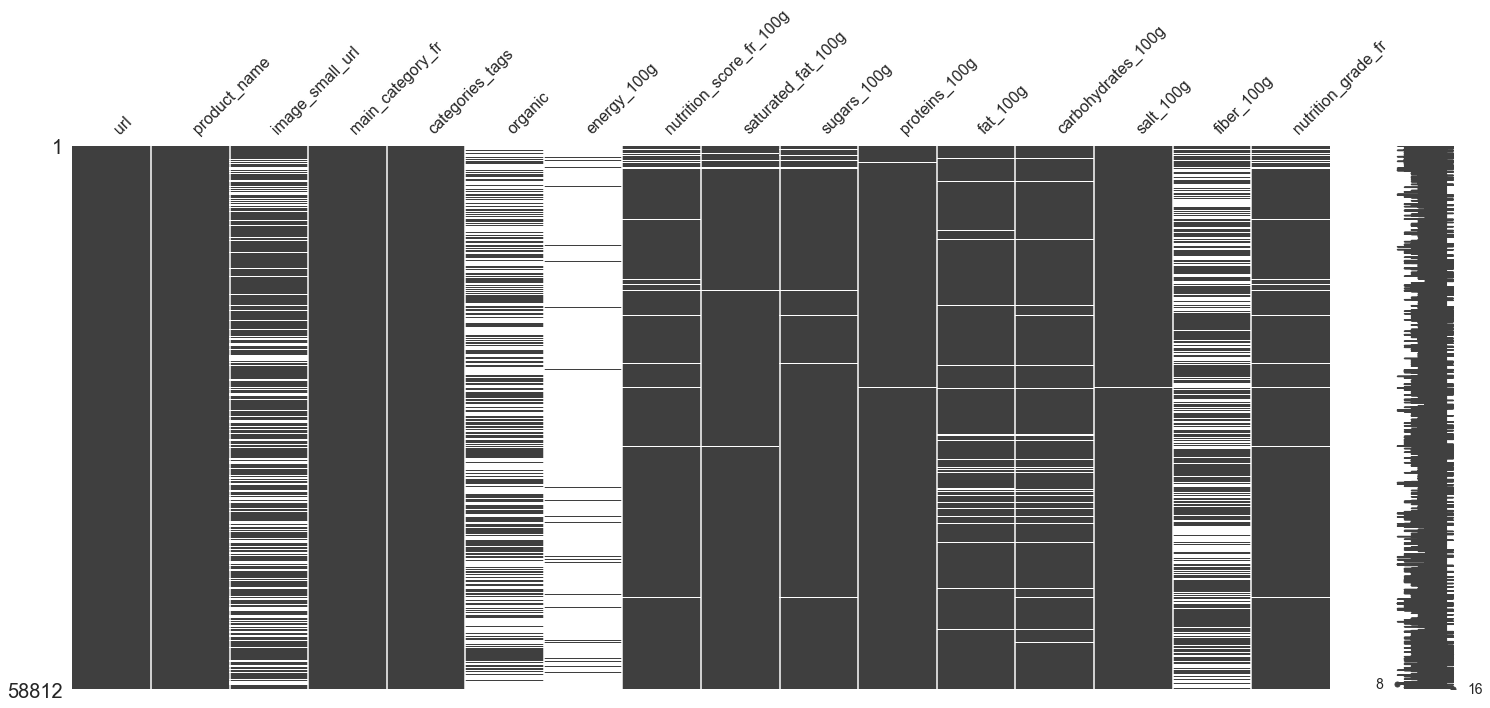

In [267]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(data, True, True)

**Photographie du produit**

On ne peut pas récupérer simplement la **photographie** d'un produit. Le choix est fait de ne **pas** effectuer **d'imputation.**

**Fibres**

Les **fibres** sont peu corrélées avec les autres nutriments, si la valeur n'est pas renseignée, elle doit être soit non connue, soit nulle. Le choix est fait de **remplacer** les valeurs manquantes par la **constante '0'**, de meme pour les variables **'energy'**, **'carbohydrades'**, et **'fat'**.

In [268]:
data['fiber_100g'] = data['fiber_100g'].fillna(0)
data['energy_100g'] = data['energy_100g'].fillna(0)
data['carbohydrates_100g'] = data['carbohydrates_100g'].fillna(0)
data['fat_100g'] = data['fat_100g'].fillna(0)

In [269]:
applied_filters['Remplissage \n par 0'] = len(data)

Valeurs manquantes :50995 NaN pour 940992 données (5.42 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes
organic,27373,46.54
image_small_url,16610,28.24
nutrition_score_fr_100g,2313,3.93
nutrition_grade_fr,2313,3.93
saturated_fat_100g,810,1.38
sugars_100g,774,1.32
salt_100g,564,0.96
proteins_100g,238,0.40


-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


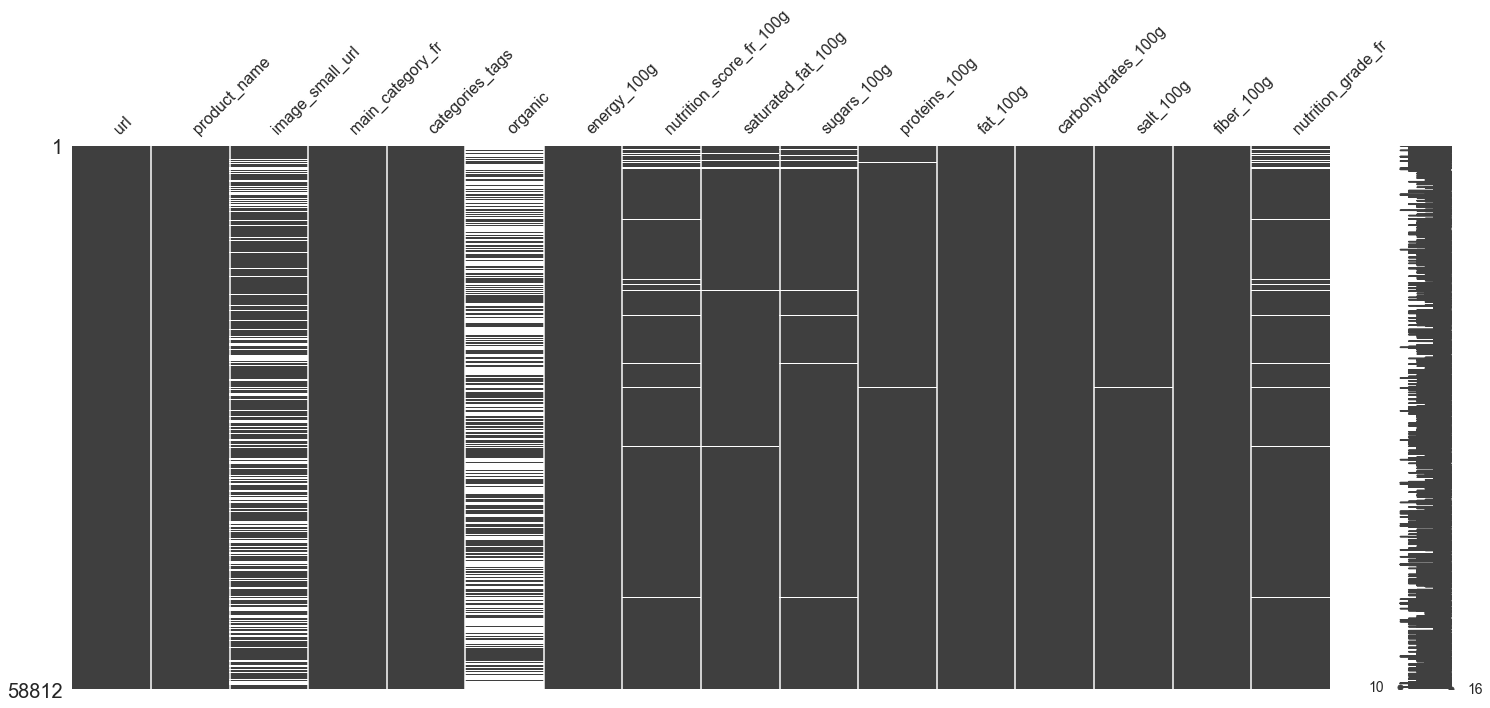

In [270]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(data, True, True)

#### 3.6) Imputation d'autres valeurs nutritionnelles à l'aide de la moyenne des catégories

In [271]:
# Définition d'une nouvelle variable avec les valeurs imputées

#final_data = data.copy(deep=True)

# Retrait des variables ayant des NaN
data = data.dropna(subset=['main_category_fr','categories_tags' ,'nutrition_score_fr_100g',
'sugars_100g',
'saturated_fat_100g',
'salt_100g',
'proteins_100g'])

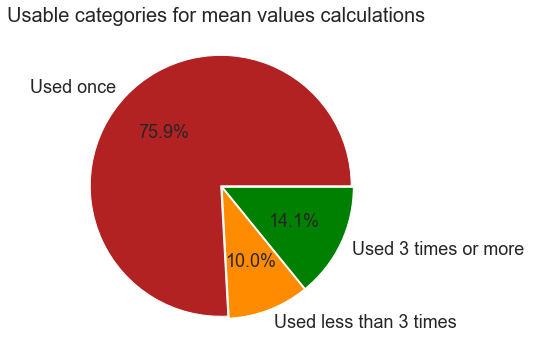

In [272]:
USE_THRESHOLD = 3
main_category_counts = data['main_category_fr'].value_counts().to_frame()
pie_chart_values = {
    'Used once': len(main_category_counts[main_category_counts['main_category_fr'] == 1])/len(main_category_counts),
    'Used less than ' + str(USE_THRESHOLD) + ' times': len(main_category_counts[(main_category_counts['main_category_fr'] > 1) & (main_category_counts['main_category_fr'] < USE_THRESHOLD)])/len(main_category_counts),
    'Used ' + str(USE_THRESHOLD) + ' times or more ': len(main_category_counts[main_category_counts['main_category_fr'] >= USE_THRESHOLD])/len(main_category_counts)
}

plt.figure(figsize=(6,6))
plt.suptitle("Usable categories for mean values calculations", fontsize=20, y=0.92)
plt.pie(pie_chart_values.values(), 
        labels=pie_chart_values.keys(), 
        autopct="%.1f%%", 
        explode=[0.01]*3, 
        colors=["firebrick", "darkorange", "green"],
        textprops={'size': 18})

# Stocker dans une liste les catégories utilisées plus de X fois (pour calculer une moyenne)

valid_categories = main_category_counts[main_category_counts['main_category_fr'] >= USE_THRESHOLD].index.to_list()

In [273]:
# Garder les variables d'interets
to_fill_data = data[(final_data['main_category_fr'].isin(valid_categories)) & (data[fonctions_data.get_nutri_col(data)].isna().any(axis=1))][fonctions_data.get_nutri_col(data) + ['main_category_fr']]

# Calcul des valeurs nutritionnelles moyennes 
categories_means = data[data['main_category_fr'].isin(valid_categories)][fonctions_data.get_nutri_col(data) + ['main_category_fr']].dropna(how="any")
categories_means = categories_means.groupby('main_category_fr').mean()

# Remplissage des données manquantes avec la moyenne de la catégorie principale du produit
for index, row in to_fill_data.iterrows():
    if row['main_category_fr'] in categories_means.index.to_list():
        for column_name in fonctions_data.get_nutri_col(data):
            if pd.isna(row[column_name]):
                data.loc[index, column_name] = categories_means.loc[row['main_category_fr'], column_name]

In [274]:
# Tout passer en majuscules
data['nutrition_grade_fr'] = data['nutrition_grade_fr'].str.upper().apply(str)
data['nutrition_grade_fr'].unique()

array(['C', 'B', 'E', 'D', 'A'], dtype=object)

In [275]:
data=data.dropna(subset=['nutrition_grade_fr'])

In [276]:
applied_filters['Remplissage \n par moy_produits'] = len(data)

Valeurs manquantes :42289 NaN pour 903968 données (4.68 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes
organic,26186,46.35
image_small_url,16103,28.50


-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


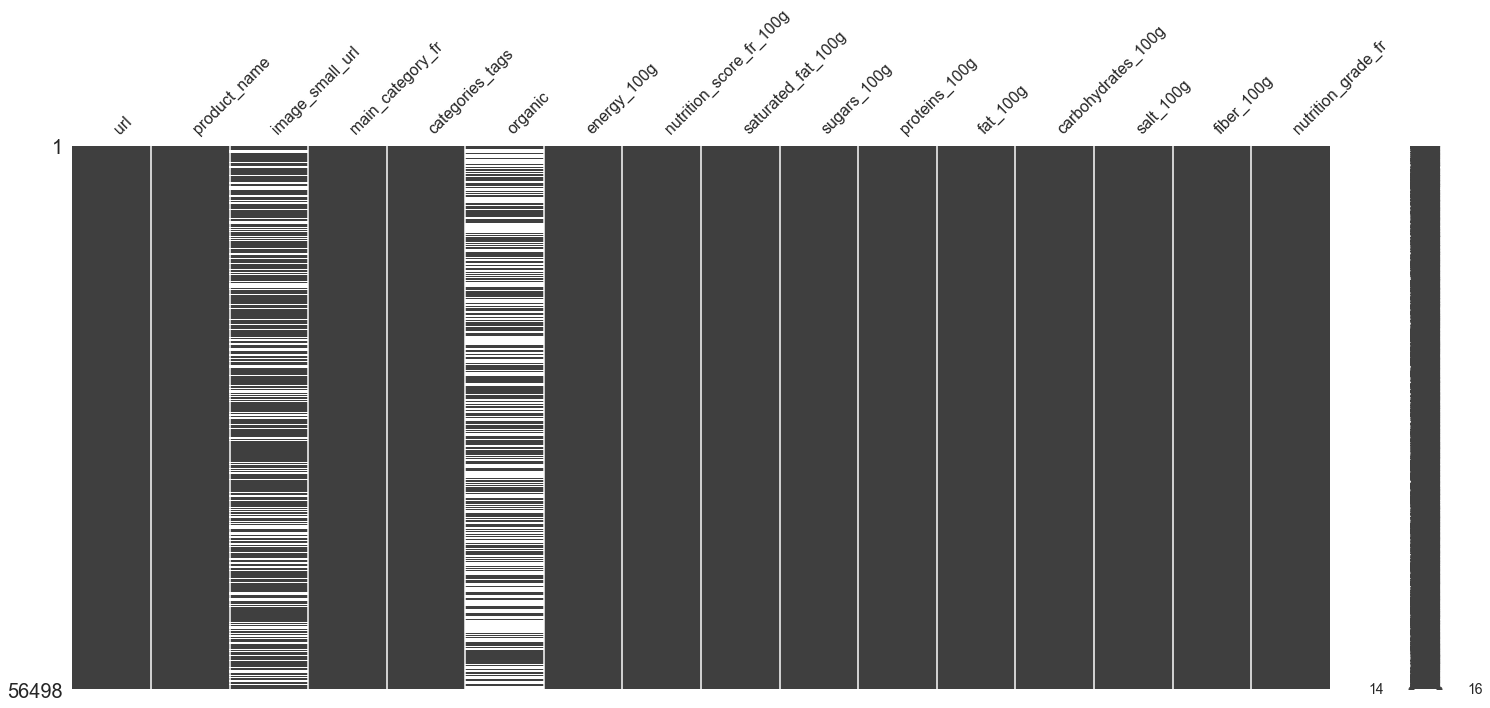

In [277]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(final_data, True, True)

#### 3.7) Résumé du  nettoyage des données 

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

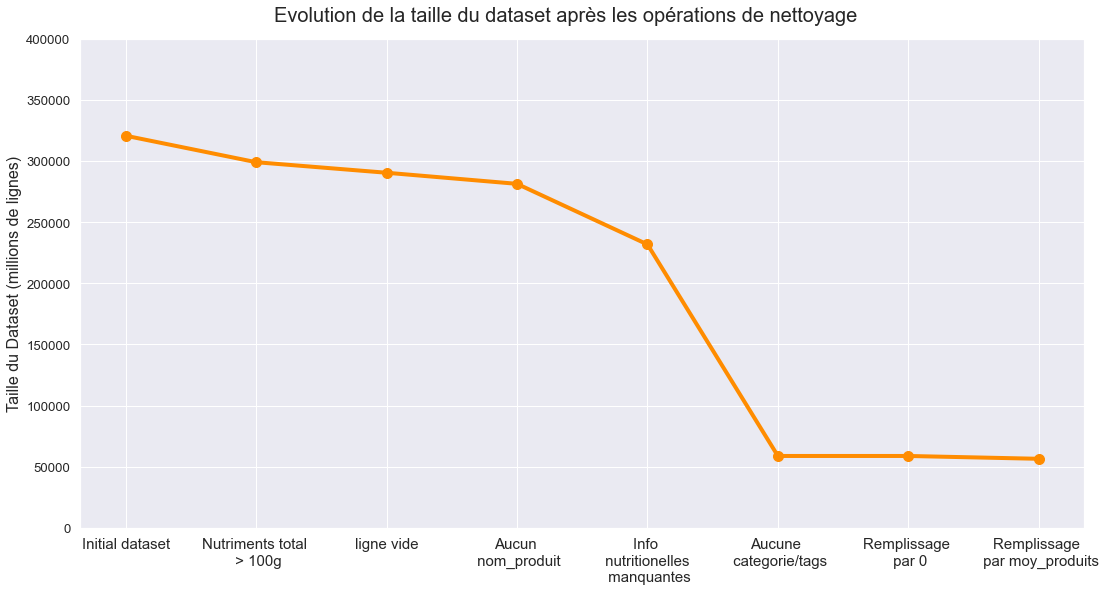

In [278]:
fig = plt.figure(figsize=(18,9))
fig.suptitle("Evolution de la taille du dataset après les opérations de nettoyage", fontsize=20, y=0.93)
fig.gca().set_ylim(ymin=0, ymax=400000)
fig.gca().set_ylabel("Taille du Dataset (millions de lignes)", fontsize=16)
plt.plot(applied_filters.keys(), applied_filters.values(), linewidth=4, color="darkorange", marker="o", markersize=10)
plt.xticks(fontsize=15)

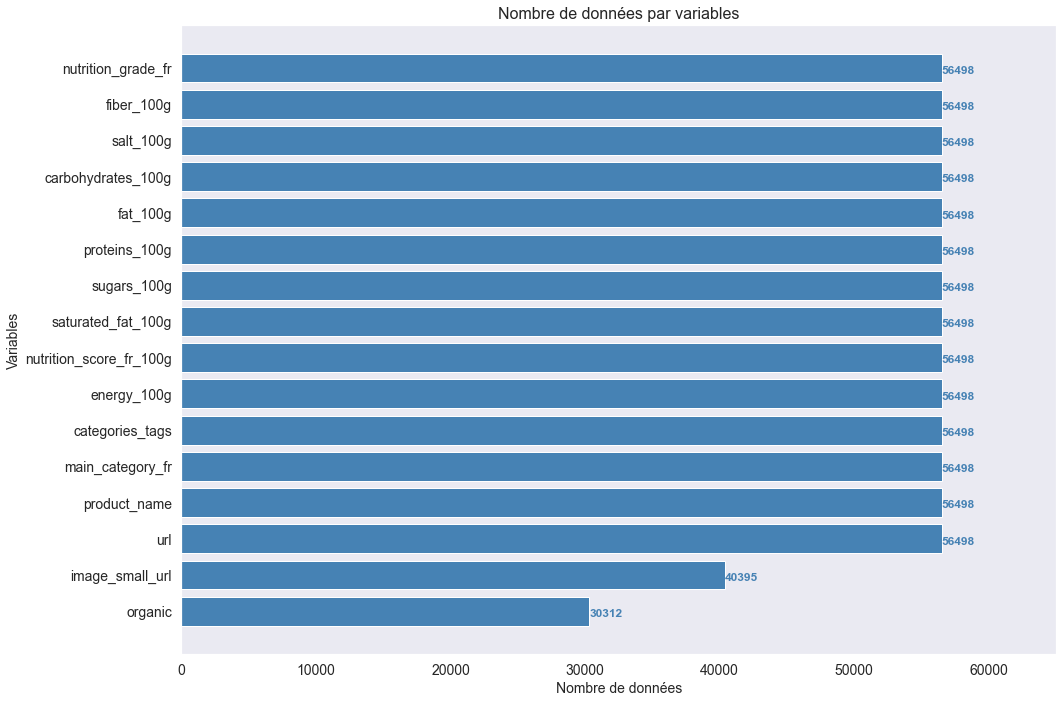

In [231]:
# Répartition des valeurs renseignées par variables
fig, ax = plt.subplots(figsize=(15, 10))

# Graphique ligne 1, colonne 1 ------------------
# Répartition des valeurs renseignées par variables
present = final_data.count()
present.sort_values(inplace=True)
ax.barh(y=present.index, width=present.values, color='SteelBlue')
for i, v in enumerate(present):
    ax.text(v + 5, i - .15, str(v), color='SteelBlue',
            fontsize=12, fontweight='bold')
ax.set_title('Nombre de données par variables', fontsize=16)
ax.set_xlabel('Nombre de données', fontsize=14)
ax.set_ylabel('Variables', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlim([0, 65000])
ax.grid(False)

fig.tight_layout()
plt.show()

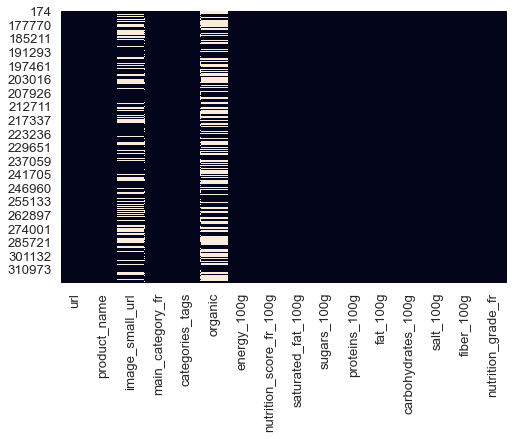

In [232]:
plt.figure(figsize=(8, 5))
sns.heatmap(final_data.isna(), cbar=False)
plt.show()

In [233]:
clean_data = final_data.copy(deep=True).reset_index().drop('index', axis="columns")
clean_data.shape

(56498, 16)

In [434]:
clean_data.to_csv('./cleaned_data.csv', sep='\t')

print(str(len(clean_data)) + " lignes ont été extraites avec succès.")

56498 lignes ont été extraites avec succès.
